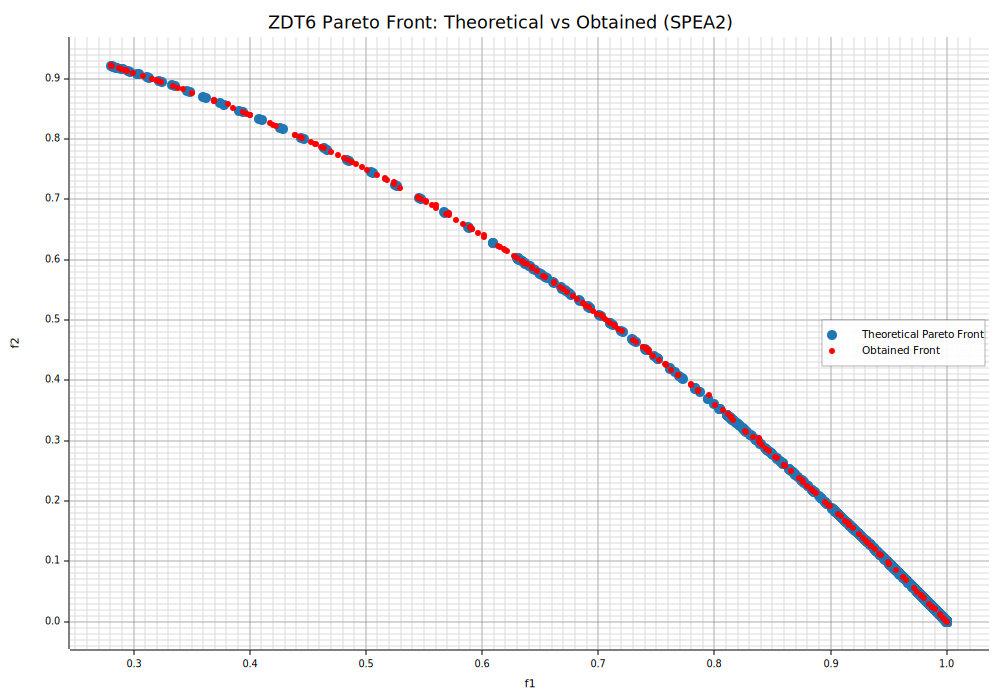

In [7]:
:dep ndarray = "*"
:dep moors = "*"
:dep plotters = "0.3.6"

use ndarray::{Array2, Axis, Ix2, s};
use moors::{
    impl_constraints_fn,
    algorithms::Spea2Builder,
    duplicates::CloseDuplicatesCleaner,
    operators::{GaussianMutation, RandomSamplingFloat, ExponentialCrossover},
    genetic::Population
};

use plotters::prelude::*;

/// Evaluate the ZDT6 objectives in a fully vectorized manner.
fn evaluate_zdt6(population: &Array2<f64>) -> Array2<f64> {
    let n = population.nrows();
    let m = population.ncols();

    let x1 = population.column(0).to_owned();
    // g = 1 + (9/(n-1)) * sum(x[1:])
    let tail = population.slice(s![.., 1..]);
    let sums = tail.sum_axis(Axis(1));
    let g = sums.mapv(|s| 1.0 + (9.0 / ((m as f64) - 1.0)) * s);

    // f1 = 1 - exp(-4*x1) * sin^6(6*pi*x1)
    let sin6 = x1.mapv(|v| (6.0 * std::f64::consts::PI * v).sin().powi(6));
    let f1 = x1.mapv(|v| 1.0) - x1.mapv(|v| (-4.0 * v).exp()) * sin6;

    // h = 1 - (f1/g)^2
    let ratio = &f1 / &g;
    let h = ratio.mapv(|r| 1.0 - r.powi(2));

    // f2 = g * h
    let f2 = &g * &h;

    let mut result = Array2::<f64>::zeros((n, 2));
    result.column_mut(0).assign(&f1);
    result.column_mut(1).assign(&f2);
    result
}

/// Compute the theoretical Pareto front for ZDT6.
fn zdt6_theoretical_front(num_points: usize) -> (Vec<f64>, Vec<f64>) {
    let mut f1: Vec<f64> = Vec::with_capacity(num_points);
    let mut f2: Vec<f64> = Vec::with_capacity(num_points);

    for i in 0..num_points {
        let x1 = if num_points > 1 {
            i as f64 / (num_points as f64 - 1.0)
        } else {
            0.0
        };
        let f1_i = 1.0 - (-4.0 * x1).exp() * (6.0 * std::f64::consts::PI * x1).sin().powi(6);
        // when g = 1 → f2 = 1 - f1^2
        let f2_i = 1.0 - f1_i.powi(2);
        f1.push(f1_i);
        f2.push(f2_i);
    }

    (f1, f2)
}

// Set up the SPEA2 algorithm for ZDT6
impl_constraints_fn!(BoundConstraints, lower_bound = 0.0, upper_bound = 1.0);

let population: Population<Ix2, Ix2> = {
    let mut algorithm = Spea2Builder::default()
        .sampler(RandomSamplingFloat::new(0.0, 1.0))
        .crossover(ExponentialCrossover::new(0.75))
        .mutation(GaussianMutation::new(0.1, 0.01))
        .duplicates_cleaner(CloseDuplicatesCleaner::new(1e-8))
        .fitness_fn(evaluate_zdt6)
        .constraints_fn(BoundConstraints)
        .num_vars(30)
        .population_size(200)
        .num_offsprings(200)
        .num_iterations(500)
        .mutation_rate(0.1)
        .crossover_rate(0.9)
        .keep_infeasible(false)
        .seed(42)
        .verbose(false)
        .build()
        .expect("Failed to build SPEA2");

    // Run SPEA2 on ZDT6
    algorithm.run().expect("SPEA2 run failed");
    algorithm.population.unwrap().clone()
};


// Get the best Pareto front obtained (as a Population instance)
let fitness = population.fitness;

// Extract the obtained fitness values (each row is [f1, f2])
let f1_found: Vec<f64> = fitness.column(0).to_vec();
let f2_found: Vec<f64> = fitness.column(1).to_vec();

// Compute the theoretical Pareto front for ZDT6
let (f1_theo, f2_theo) = zdt6_theoretical_front(1000);

// Plot the theoretical Pareto front and the obtained front
let mut svg = String::new();
{
    let backend = SVGBackend::with_string(&mut svg, (1000, 700));
    let root = backend.into_drawing_area();
    root.fill(&WHITE).unwrap();

    // Compute min/max from actual data
    let (mut x_min, mut x_max) = (f1_theo[0], f1_theo[0]);
    let (mut y_min, mut y_max) = (f2_theo[0], f2_theo[0]);
    
    for &x in f1_theo.iter().chain(f1_found.iter()) {
        if x < x_min { x_min = x; }
        if x > x_max { x_max = x; }
    }
    for &y in f2_theo.iter().chain(f2_found.iter()) {
        if y < y_min { y_min = y; }
        if y > y_max { y_max = y; }
    }
    
    // Add a small margin (5%)
    let xr = (x_max - x_min).max(1e-9);
    let yr = (y_max - y_min).max(1e-9);
    x_min -= xr * 0.05;
    x_max += xr * 0.05;
    y_min -= yr * 0.05;
    y_max += yr * 0.05;

    let mut chart = ChartBuilder::on(&root)
        .caption("ZDT6 Pareto Front: Theoretical vs Obtained (SPEA2)", ("DejaVu Sans", 22))
        .margin(10)
        .x_label_area_size(40)
        .y_label_area_size(60)
        .build_cartesian_2d(x_min..x_max, y_min..y_max)
        .unwrap();

    chart.configure_mesh()
        .x_desc("f1")
        .y_desc("f2")
        .axis_desc_style(("DejaVu Sans", 14))
        .light_line_style(&RGBColor(220, 220, 220))
        .draw()
        .unwrap();

    // Plot theoretical front as blue markers.
    chart.draw_series(
        f1_theo.iter().zip(f2_theo.iter()).map(|(&x, &y)| {
            Circle::new((x, y), 5, RGBColor(31, 119, 180).filled())
        })
    ).unwrap()
     .label("Theoretical Pareto Front")
     .legend(|(x, y)| Circle::new((x, y), 5, RGBColor(31, 119, 180).filled()));

    // Plot obtained front as red circles.
    chart.draw_series(
        f1_found.iter().zip(f2_found.iter()).map(|(&x, &y)| {
            Circle::new((x, y), 3, RGBColor(255, 0, 0).filled())
        })
    ).unwrap()
     .label("Obtained Front")
     .legend(|(x, y)| Circle::new((x, y), 3, RGBColor(255, 0, 0).filled()));

    chart.configure_series_labels()
        .border_style(&RGBAColor(0, 0, 0, 0.3))
        .background_style(&WHITE.mix(0.9))
        .label_font(("DejaVu Sans", 13))
        .draw()
        .unwrap();

    root.present().unwrap();
}

// Emit as rich output for evcxr
println!("EVCXR_BEGIN_CONTENT image/svg+xml\n{}\nEVCXR_END_CONTENT", svg);